# Network Architectures for Tabular Data

## Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Ordinal Variables

### Load in the data

In [2]:
freq = pd.read_csv("french-motor.csv").drop("IDpol", axis=1).head(25_000)
freq.sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
17834,0.0,0.12,C,6.0,10.0,61.0,50.0,B2,Diesel,392.0,R82
13942,0.0,0.02,D,6.0,6.0,61.0,50.0,B2,Diesel,798.0,R54
3084,1.0,0.48,D,6.0,1.0,41.0,57.0,B12,Diesel,720.0,R73


### Split into training and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
  freq.drop("ClaimNb", axis=1), freq["ClaimNb"], random_state=2022)

X_train = X_train.reset_index(drop=True) # Index starts at 0 again.
X_test = X_test.reset_index(drop=True)

### Ordinal & binary categories

In [4]:
# Using OrdinalEncoder to encode categorical features to an integer array
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(X_train[["Area", "VehGas"]])
oe.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object),
 array(['Diesel', 'Regular'], dtype=object)]

In [5]:
# To demonstrate the effect of the OrdinalEncoder and what values the features have been encoded to
for i, area in enumerate(oe.categories_[0]):
    print(f"The Area value {area} gets turned into {i}.")

The Area value A gets turned into 0.
The Area value B gets turned into 1.
The Area value C gets turned into 2.
The Area value D gets turned into 3.
The Area value E gets turned into 4.
The Area value F gets turned into 5.


In [6]:
X_train_ord = oe.transform(X_train[["Area", "VehGas"]])
X_test_ord = oe.transform(X_test[["Area", "VehGas"]])

In [7]:
# Apply the OrdinalEncoder to the training and test sets
ct = make_column_transformer(
  (OrdinalEncoder(), ["Area", "VehGas"]),
  ("drop", ["VehBrand", "Region"]),
  remainder=StandardScaler()
)
X_train_ct = ct.fit_transform(X_train)

## Categorical Variables and Entity Embeddings
Embedding is a mapping of a categorical variable into an n-dimensional vector. The matrix allows us to discover non-linear relationships.


### 1 categorical variable

In [8]:
oe = OrdinalEncoder()
X_train_reg = oe.fit_transform(X_train[["Region"]])
X_test_reg = oe.transform(X_test[["Region"]])

for i, reg in enumerate(oe.categories_[0][:3]):
  print(f"The Region value {reg} gets turned into {i}.")

The Region value R11 gets turned into 0.
The Region value R21 gets turned into 1.
The Region value R22 gets turned into 2.


In [9]:
# Create the model
from tensorflow.keras.layers import Embedding
NUM_REGIONS = len(np.unique(X_train[["Region"]]))

tf.random.set_seed(12)
model = Sequential([
  Embedding(input_dim=NUM_REGIONS, output_dim=2),
  Dense(1, activation="exponential")
])

model.compile(optimizer="adam", loss="poisson")

# Fitting the model
es = EarlyStopping(verbose=True)
hist = model.fit(X_train_reg, y_train, epochs=100, verbose=False,
    validation_split=0.2, callbacks=[es])
hist.history["val_loss"][-1]

Epoch 2: early stopping


0.7615119814872742

In [10]:
# Embedding Layer
model.layers[0].get_weights()[0]

array([[ 0.07579127, -0.09698265],
       [-0.02545219,  0.02037343],
       [-0.02193114,  0.02019609],
       [ 0.10964777, -0.07145162],
       [ 0.28104314, -0.35352397],
       [ 0.24430592, -0.22409698],
       [ 0.20545132, -0.25034478],
       [-0.08415247,  0.1411713 ],
       [ 0.39271775, -0.317791  ],
       [-0.01779692, -0.03396926],
       [ 0.05147856, -0.10029511],
       [ 0.43893147, -0.37886578],
       [ 0.21585901, -0.2490051 ],
       [ 0.37309232, -0.4300747 ],
       [-0.06571068,  0.02424351],
       [-0.04966045,  0.07198226],
       [ 0.17270812, -0.25676844],
       [ 0.32889083, -0.31970406],
       [ 0.15872598, -0.11443847],
       [-0.0698033 ,  0.03172505],
       [-0.04183149,  0.07438329],
       [-0.15571742,  0.06051371]], dtype=float32)

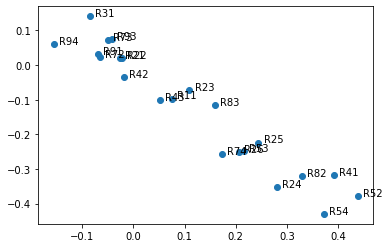

In [11]:
# plotting the embeddings
points = model.layers[0].get_weights()[0]
plt.scatter(points[:,0], points[:,1])
for i in range(NUM_REGIONS):
  plt.text(points[i,0]+0.01, points[i,1] , s=oe.categories_[0][i])

Desired structure - embeddings + other inputs

<img src = "Embeddings & other inputs.PNG" width="500"/> 

This cannot be done with Sequential models...

## Keras' Functional API

In [12]:
# Packages required
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

### Converting Sequential models

In [13]:
# Method 1 to create model - sequential
tf.random.set_seed(12)

model = Sequential([
  Dense(30, "relu"),
  Dense(1, "exponential")
])

model.compile(
  optimizer="adam",
  loss="poisson")

hist = model.fit(
  X_train_ord, y_train,
  epochs=1, verbose=0,
  validation_split=0.2)
hist.history["val_loss"][-1]

0.7956936359405518

In [14]:
# Method 2 to create model - inputs and outputs
tf.random.set_seed(12)

inputs = Input(shape=(2,))
x = Dense(30, "relu")(inputs)
out = Dense(1, "exponential")(x)
model = Model(inputs, out)

model.compile(
  optimizer="adam",
  loss="poisson")

hist = model.fit(
  X_train_ord, y_train,
  epochs=1, verbose=0,
  validation_split=0.2)
hist.history["val_loss"][-1]

0.7956936359405518

## Wide and Deep Network Architecture

<img src = "Wide and Deep Network.PNG" width="200"/>

In [15]:
from tensorflow.keras.layers \
    import Concatenate

input_ = Input(shape=X_train.shape[1:], name="input")
hidden1 = Dense(30, activation="relu", name="hidden1")(input_)
hidden2 = Dense(30, activation="relu", name="hidden2")(hidden1)
concat = Concatenate(name="combined")([input_, hidden2])
output = Dense(1, name="output")(concat)
model = Model(inputs=[input_], outputs=[output])

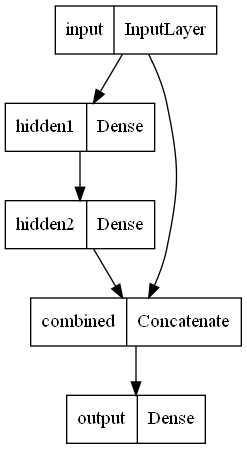

In [16]:
# Inspect the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [17]:
model.summary(line_length=75)

Model: "model_1"
___________________________________________________________________________
 Layer (type)           Output Shape     Param #  Connected to             
 input (InputLayer)     [(None, 10)]     0        []                       
                                                                           
 hidden1 (Dense)        (None, 30)       330      ['input[0][0]']          
                                                                           
 hidden2 (Dense)        (None, 30)       930      ['hidden1[0][0]']        
                                                                           
 combined (Concatenate)  (None, 40)      0        ['input[0][0]',          
                                                   'hidden2[0][0]']        
                                                                           
 output (Dense)         (None, 1)        41       ['combined[0][0]']       
                                                                       

## French Motor Dataset with Embeddings

### Pre-process the inputs

In [18]:
# Transform the categorical variables to integers
NUM_BRANDS, NUM_REGIONS = X_train.nunique()[["VehBrand", "Region"]]

ct = make_column_transformer(
  (OrdinalEncoder(), ["VehBrand", "Region", "Area", "VehGas"]),
  remainder=StandardScaler()
)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

In [19]:
# Split the brand and region data apart from the rest
X_train_brand = X_train_ct[:,0]; X_test_brand = X_test_ct[:,0]
X_train_region = X_train_ct[:,1]; X_test_region = X_test_ct[:,1]
X_train_rest = X_train_ct[:,2:]; X_test_rest = X_test_ct[:,2:]

### Organise the inputs

In [20]:
# Make a Keras Input for: vehical brand, region and others
vehBrand = Input(shape=(1,), name="vehBrand")
region = Input(shape=(1,), name="region")
otherInputs = Input(shape=X_train_rest.shape[1:], name="otherInputs")

In [21]:
# Create embeddings and join them with the other inputs.
from tensorflow.keras.layers import Reshape

tf.random.set_seed(1337)
vehBrandEE = Embedding(input_dim=NUM_BRANDS, output_dim=2,
    name="vehBrandEE")(vehBrand)
vehBrandEE = Reshape(target_shape=(2,))(vehBrandEE)

regionEE = Embedding(input_dim=NUM_REGIONS, output_dim=2,
    name="regionEE")(region)
regionEE = Reshape(target_shape=(2,))(regionEE)

x = Concatenate(name="combined")([vehBrandEE, regionEE, otherInputs])

### Complete the model and fit it

In [22]:
x = Dense(30, "relu", name="hidden")(x)
out = Dense(1, "exponential", name="out")(x)

model = Model([vehBrand, region, otherInputs], out)
model.compile(optimizer="adam", loss="poisson")

hist = model.fit((X_train_brand, X_train_region, X_train_rest),
    y_train, epochs=100, verbose=0,
    callbacks=[EarlyStopping(patience=5)], validation_split=0.2)
np.min(hist.history["val_loss"])

0.6861889958381653

### Plotting this model

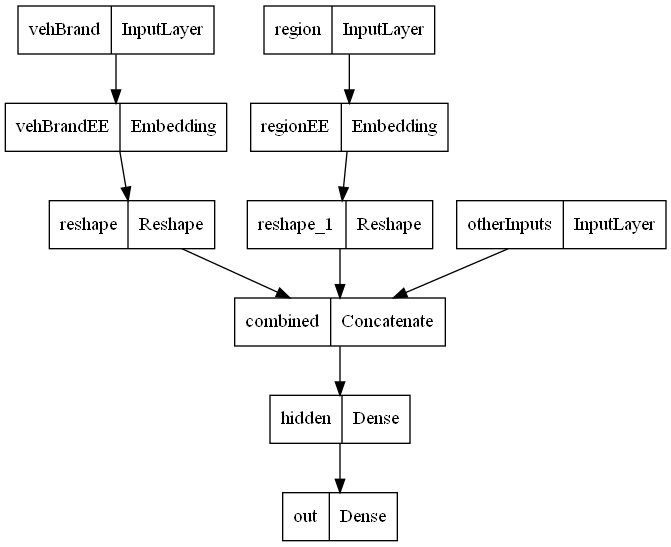

In [23]:
plot_model(model)

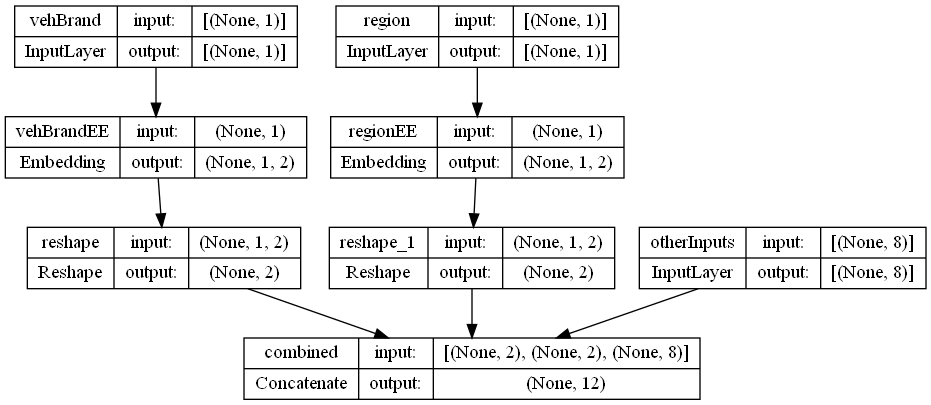

In [24]:
# Why we need to reshape
plot_model(model, layer_range=("", "combined"), show_shapes=True)

### Slicing up one Input

In [25]:
tf.random.set_seed(1337)
inputs = Input(shape=(X_train_ct.shape[1],))

vehBrandEE = Embedding(input_dim=NUM_BRANDS, output_dim=2, name="vehBrandEE")(inputs[:,0])
regionEE = Embedding(input_dim=NUM_REGIONS, output_dim=2, name="regionEE")(inputs[:,1])

x = Concatenate(name="combined")([vehBrandEE, regionEE, inputs[:,2:]])
x = Dense(30, "relu", name="hidden")(x)
out = Dense(1, "exponential", name="out")(x)

model = Model(inputs, out)
model.compile(optimizer="adam", loss="poisson")

hist = model.fit(X_train_ct, y_train, epochs=100, verbose=0, callbacks=[EarlyStopping(patience=5)], validation_split=0.2)
np.min(hist.history["val_loss"])

0.6861889958381653

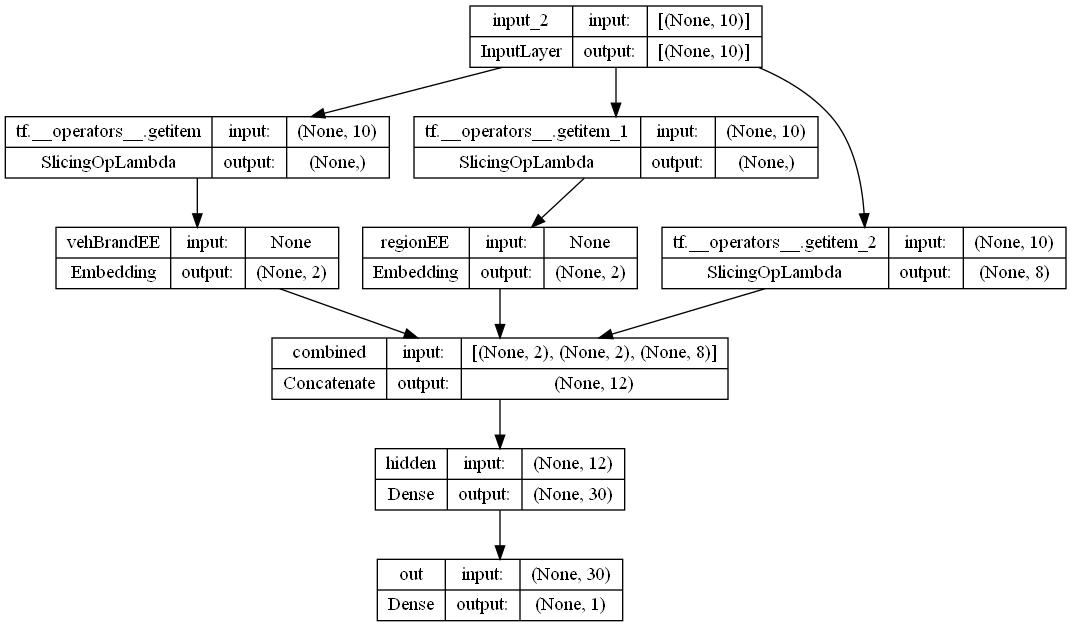

In [26]:
plot_model(model, show_shapes=True)

### Scale by Exposure

We have $\{(x_i,y_i)\}_{i=1,...,n}$ for $x_i \in \mathbb{R}^{47}$ and $y_i \in \mathbb{N}_0$

- **MODEL 1**: $Y_i$ ~ Poisson($\lambda (x_i)$)

    But the exposures are different for each policy. 

    $\lambda (x_i)$ is the expected number of claims for the duration of policy i's contract


- **MODEL 2**: $Y_i$ ~ Poisson($Exposure_i \times \lambda (x_i)$)
    
    $Exposure_i\not \in x_i$ 
    
    $\lambda(x_i)$ is the rate per year

#### Just take continuous variables

In [27]:
ct = make_column_transformer(
  ("passthrough", ["Exposure"]),
  ("drop", ["VehBrand", "Region", "Area", "VehGas"]),
  remainder=StandardScaler()
)
X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

In [28]:
# split exposure apart from the rest
X_train_exp = X_train_ct[:,0]; X_test_exp = X_test_ct[:,0]
X_train_rest = X_train_ct[:,1:]; X_test_rest = X_test_ct[:,1:]

In [29]:
# organise the inputs
exposure = Input(shape=(1,), name="exposure")
otherInputs = Input(shape=X_train_rest.shape[1:], name="otherInputs")

In [30]:
# Make & fit the model
# Feed the continuous inputs to some normal dense layers.
tf.random.set_seed(1337)
x = Dense(30, "relu", name="hidden1")(otherInputs)
x = Dense(30, "relu", name="hidden2")(x)
lambda_ = Dense(1, "exponential", name="lambda")(x)

from tensorflow.keras.layers import Multiply

out = Multiply(name="out")([lambda_, exposure])
model = Model([exposure, otherInputs], out)
model.compile(optimizer="adam", loss="poisson")

es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
hist = model.fit((X_train_exp, X_train_rest), y_train, epochs=100, verbose=0, callbacks=[es], validation_split=0.2)
np.min(hist.history["val_loss"])

KeyboardInterrupt: 

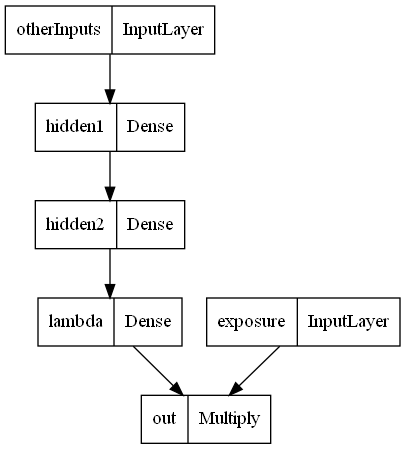

In [ ]:
plot_model(model)

## Multi-task Learning - Swedish third party motor insurance

### Import data and split into training and test

In [ ]:
url = "http://www.statsci.org/data/general/motorins.txt"
df = pd.read_csv(url, sep="\t") \
  .assign(
    frequency = lambda x: x.Claims / x.Insured,
    severity = lambda x: np.where(x.Claims == 0, 0, x.Payment / x.Claims),
    risk_premium = lambda x: x.Payment / x.Insured
  )
train, test = train_test_split(df, test_size=0.2, random_state=12345)
df.head(3)

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,frequency,severity,risk_premium
0,1,1,1,1,455.13,108,392491,0.237295,3634.175926,862.371191
1,1,1,1,2,69.17,19,46221,0.274686,2432.684211,668.223218
2,1,1,1,3,72.88,13,15694,0.178375,1207.230769,215.340285


### Summarise the targets

In [ ]:
totals = train.loc[:, ["Insured", "Claims", "Payment"]].agg('sum')
train_average_frequency = totals["Claims"] / totals["Insured"]
train_average_severity = totals["Payment"] / totals["Claims"]
train_average_risk_premium = totals["Payment"] / totals["Insured"]
print(train_average_frequency,
  train_average_severity,
  train_average_risk_premium)

0.0474910948615842 4959.405313081085 235.5275881805785


### Organise the inputs

In [ ]:
zone_input = Input(shape=(1,), name='zone_input') 
make_input = Input(shape=(1,), name='make_input')

zone_embedding = Embedding(output_dim=2, input_dim=7)(zone_input)
zone_embedding = Reshape(target_shape=(2,))(zone_embedding)
make_embedding = Embedding(output_dim=2, input_dim=9)(make_input)
make_embedding = Reshape(target_shape=(2,))(make_embedding)

kilometres_input = Input(shape=(1,), name='kilometres_input') 
bonus_input = Input(shape=(1,), name='bonus_input')

x = Concatenate(name="combined")(
  [zone_embedding, make_embedding, kilometres_input, bonus_input])

### Add layers and outputs, create model

In [ ]:
x = Dense(64, activation='relu')(x) 
x = Dense(64, activation='relu')(x) 
x = Dense(64, activation='relu')(x)

frequency_output = Dense(1, activation='relu', name='frequency')(x) 
severity_output = Dense(1, activation='relu', name='severity')(x) 
risk_premium_output = Dense(1, activation='relu', name='risk_premium')(x)

model = Model(
    inputs=[zone_input, make_input, kilometres_input, bonus_input], 
    outputs=[frequency_output, severity_output, risk_premium_output])

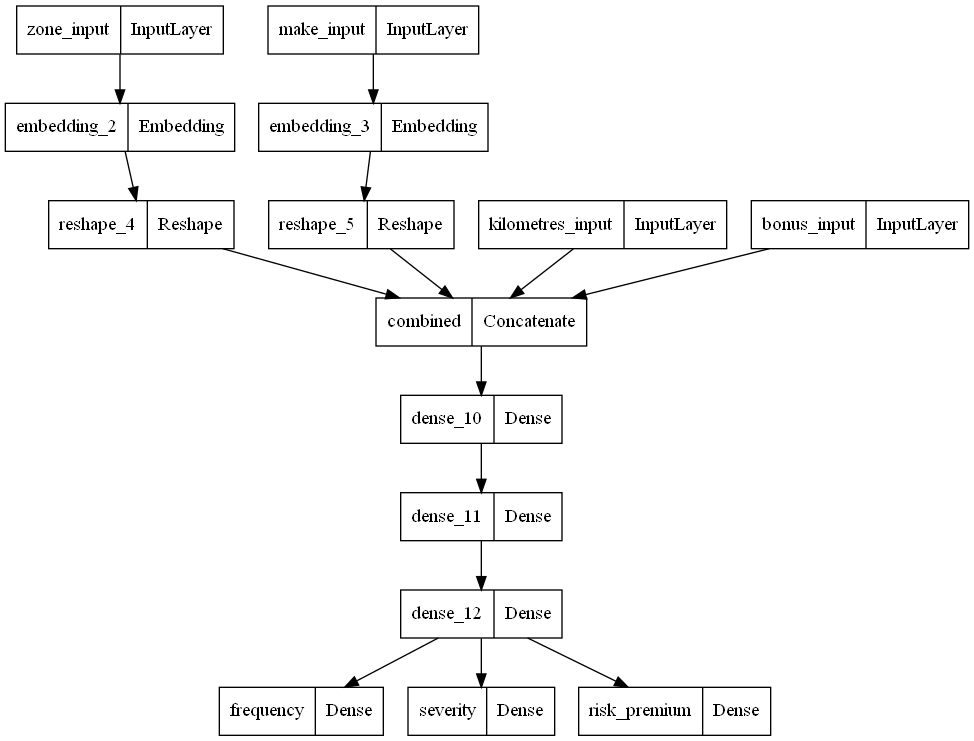

In [ ]:
plot_model(model)

### Prepare model and data for fitting

In [ ]:
model.compile(optimizer='adam', 
  loss = {
    'risk_premium': 'mean_squared_error',
    'frequency': 'poisson',
    'severity': 'mean_squared_logarithmic_error'
  }, 
  loss_weights = {
    'risk_premium': 1.0,
    'frequency': 1.0,
    'severity': 1.0
  })

In [ ]:
def InputDataTransformer(x):
  return {
  'kilometres_input': (x.Kilometres.values - 1) / 5,
  'zone_input': x.Zone.values - 1,
  'bonus_input': (x.Bonus.values - 1) / 7,
  'make_input': x.Make.values - 1}

### Fit the data

In [ ]:
model.fit(
  InputDataTransformer(train),
  {
    'frequency': train.frequency.values/train_average_frequency,
    'severity': train.severity.values/train_average_severity,
    'risk_premium': train.risk_premium.values/train_average_risk_premium
  }, 
  sample_weight = {
    'frequency': train.Insured.values,
    'severity': train.Claims.values,
    'risk_premium': train.Insured.values
  },
  epochs=40, batch_size=32, verbose=0);

## Keras Eager Execution

### Find dead ReLU neurons

In [ ]:
acts = model.get_layer("hidden")(X_train.to_numpy()).numpy()
acts.mean(axis=0)
np.sum(acts.mean(axis=0) == 0)

### Trying different seeds 

In [ ]:
#Create a function which counts the number of dead ReLU neurons in the first hidden layer for a given seed
def count_dead(seed):
    tf.random.set_seed(seed)
    hidden = Dense(30, activation="relu")
    acts = hidden(X_train.to_numpy()).numpy()
    return np.sum(acts.mean(axis=0) == 0)

# find mediuan dead neurons
numDead = [count_dead(seed) for seed in range(1_000)]
np.median(numDead)

In [ ]:
# distribution of dead ReLus
labels, counts = np.unique(numDead, return_counts=True)
plt.bar(labels, counts, align='center');

## Regularisation

### Traditional regularisation
Say all the m weights are in the vector θ. We can change the loss functions to:

**$l_1 regularisation$**
$$ Loss _{1:n} = 1/n \sum_{i=1}^n Loss_i + \lambda \sum_{j=1} ^m |{\theta_j}|$$

**$l_2 regularisation$**
$$ Loss _{1:n} = 1/n \sum_{i=1}^n Loss_i + \lambda \sum_{j=1} ^m |{\theta_j^2}|$$


In [ ]:
from tensorflow.keras.regularizers import l1, l2

def l1_model(regulariserStrength=0.01):
  tf.random.set_seed(123)
  model = Sequential([
      Dense(30,
        activation="leaky_relu",
        name="hidden1"),
      Dense(30,
        activation="leaky_relu",
        kernel_regularizer=l1(regulariserStrength),
        name="hidden2"),
      Dense(1, 
        activation="exponential",
        name="output")
  ])

  model.compile("adam", "mse")
  model.fit(X_train_sc, y_train, epochs=4, verbose=0)
  return model

### Weights before and after $l_1$

In [ ]:
model = l1_model(0)
weights = model.get_layer("hidden2").get_weights()[0].flatten()
print(f"Number of weights almost 0: {np.sum(np.abs(weights) < 1e-5)}")
plt.hist(weights, bins=100);

In [ ]:
model = l1_model(0.1)
weights = model.get_layer("hidden2").get_weights()[0].flatten()
print(f"Number of weights almost 0: {np.sum(np.abs(weights) < 1e-5)}")
plt.hist(weights, bins=100);

## Dropout

- Type of explicit regularisation 
- In each layer, neurons are randomly dropped by a specified probability
- Each neuron has to be as useful as possible on neurons trained with dropout cannot co-adapt with their neighbouring neurons
- Cannot rely excessively on just a few input neurons --> must pay attention to each of their input neurons
- results in a more robust network that generalises better

<img src = "Dropout.PNG"/> 

In [ ]:
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
model = Sequential([
    Dense(30, activation="leaky_relu", name="hidden1"),
    Dropout(0.2),
    Dense(30, activation="leaky_relu", name="hidden2"),
    Dropout(0.2),
    Dense(1, activation="exponential", name="output")
])

model.compile("adam", "mse")
model.fit(X_train_sc, y_train, epochs=4, verbose=0);

### Making predictions

In [ ]:
# as usual
model.predict(X_test_sc[:3,:])

In [ ]:
# make model think it is still training
model(X_test_sc[:3,:], training=True)

### Monte Carlo Dropout

In [ ]:
## intentionally leave dropout on when making predictions
predictions = [model(X_test_sc[:3,:], training=True) for _ in range(10)]
allPredictions = np.concatenate(predictions, axis=1)
np.mean(allPredictions, axis=1)